In [87]:
# Standard libraries
import os
import json
import requests
from collections import defaultdict
import copy
import sys
from contextlib import contextmanager
import datetime
from collections import Counter


# Scientific and array libraries
import numpy as np

# PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# torchvision
from torchvision.models import ResNet18_Weights
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

# Visualization
import matplotlib.pyplot as plt

# Data handling and annotation
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from pycocotools.cocoeval import COCOeval

# Progress bar
from tqdm import tqdm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Sklearn
from sklearn.model_selection import train_test_split

# Matplot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Global Variables

In [88]:
val_dir = '../annotations/instances_val2017.json'
train_dir = '../annotations/instances_train2017.json'
random_seed = 42

# Description of Data and Methodology
## Problem Overview
This project focuses on solving an instance segmentation task using the COCO (Common Objects in Context) dataset. Instance segmentation involves detecting objects in an image, classifying them, and delineating each object with a pixel-level mask. 

## Dataset Description
We use the COCO 2017 dataset, a widely-used benchmark for object detection, segmentation, and captioning tasks. The dataset consists of:

Training Set: ~118,000 images

Validation Set: ~5,000 images

Categories: 80 object categories (e.g., person, car, dog, bicycle)

Annotations: Bounding boxes, segmentation masks, and keypoints per object instance

Each annotation includes detailed metadata such as category ID, iscrowd flag, segmentation polygons, and image ID. This allows for a diverse and complex training set ideal for training robust models.

## Preprocessing and Augmentation
Images and annotations were parsed using the pycocotools API. Data augmentation was applied using the albumentations library to improve generalization. Transformations include resizing, random horizontal flips, color jittering, and normalization. These transformations were applied both to the image and the corresponding masks to maintain alignment.


# Custom Dataset

In [89]:
class CocoSegmentationDataset(Dataset):
    def __init__(
        self, 
        annotation_directory, 
        target_categories, 
        negative_categories=None, 
        transforms=None, 
        target_samples=None, 
        negative_samples=None, 
        verbose=False, 
        image_directory = '../images',
        train_ratio=0.8,
        val_ratio=0.1,
        test_ratio=0.1,
        split='train',
        random_seed=42):
        
        self.verbose = verbose
        self.transforms = transforms
        
        self.desired_target_samples = target_samples
        self.desired_negative_samples = negative_samples
        self.target_categories = target_categories
        self.negative_categories = negative_categories
        
        self.random_seed = random_seed
        self.train_ratio=train_ratio
        self.val_ratio=val_ratio
        self.test_ratio=test_ratio
        
        #create a directory to store images
        self.img_dir = image_directory
        os.makedirs(self.img_dir, exist_ok=True)
        
        # Initialize COCO API and get data during instantiation
        self.coco = COCO(annotation_directory)
        
        self.target_ids, self.negative_ids, self.all_category_ids, self.current_image_ids = self._instantiate_ids()
        self.all_image_ids = self.current_image_ids

        self.catId_to_label, self.label_to_catId = self._create_dictionaries()
        self._download_images()
            
        self.train_image_ids, self.val_image_ids, self.test_image_ids = self._split_dataset()
        self.choose_split(split)

    def __len__(self):
        return len(self.current_image_ids)
        
    def _get_ordered_category_ids(self, categories):
        category_ids = []
        
        if categories != None:
            for single_category in categories:
                single_id = self.coco.getCatIds(catNms=single_category)
                category_ids += single_id
        
        return category_ids
    
    def _instantiate_ids(self):
        # Get category IDs
        target_ids = self._get_ordered_category_ids(self.target_categories)
        negative_ids = self._get_ordered_category_ids(self.negative_categories)

        # Sets to store unique image ids
        target_image_ids = set()
        negative_image_ids = set()

        # Collect up to N images per target category
        for cat_id in target_ids:
            img_ids = self.coco.getImgIds(catIds=cat_id)
            if self.desired_target_samples is not None:
                num_to_sample = min(self.desired_target_samples, len(img_ids))
                img_ids = img_ids[:num_to_sample]
            target_image_ids.update(img_ids)

        # Collect up to N images per negative category
        for cat_id in negative_ids:
            img_ids = self.coco.getImgIds(catIds=cat_id)
            if self.desired_negative_samples is not None:
                num_to_sample = min(self.desired_negative_samples, len(img_ids))
                img_ids = img_ids[:num_to_sample]
            negative_image_ids.update(img_ids)

        # Combine
        image_ids = list(target_image_ids.union(negative_image_ids))
        all_category_ids = target_ids + negative_ids

        return target_ids, negative_ids, all_category_ids, image_ids

    def _download_images(self):
        print(f'Verifying Local Images...')
        for img_id in tqdm(self.all_image_ids):
            img_info = self.coco.loadImgs(img_id)[0]
            file_name = img_info['file_name']
            img_path = os.path.join(self.img_dir, file_name)

            if not os.path.exists(img_path):
                url = img_info.get('coco_url') or img_info.get('flickr_url')
                if url is None:
                    if self.verbose: print(f"No URL found for image {img_id}")
                    continue

                if self.verbose: print(f"Downloading {file_name} from {url}")

                try:
                    response = requests.get(url, stream=True)
                    response.raise_for_status()
                    with open(img_path, 'wb') as out_file:
                        for chunk in response.iter_content(chunk_size=8192):
                            out_file.write(chunk)
                except Exception as e:
                    if self.verbose: print(f"Failed to download image {file_name}: {e}")
    
    def _create_dictionaries(self):
        categoryid_to_label = {}
        label_to_categoryname = {}
        
        #assign a unique label for every target class
        current_label = 1
        for target_id in self.target_ids:
            categoryid_to_label[target_id] = current_label
            label_to_categoryname[current_label] = self.coco.loadCats(target_id)[0]['name']
            current_label += 1
        
        for negative_id in self.negative_ids:
            categoryid_to_label[negative_id] = current_label
        
        label_to_categoryname[current_label] = 'other'
        
        return categoryid_to_label, label_to_categoryname

    def __getitem__(self, idx):
        #Get the image
        img_id = self.current_image_ids[idx] #get the image id for a specific index
        img_info = self.coco.loadImgs(img_id)[0] #load intos information
        img_path = os.path.join(self.img_dir, img_info['file_name']) #get its local path
        image = Image.open(img_path).convert("RGB") #load the image
        
        #get its annotation information
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.all_category_ids)
        anns = self.coco.loadAnns(ann_ids)
        
        # Filter out crowd annotations
        anns = [ann for ann in anns if ann['iscrowd'] == 0]
        
        #instantiate target lists
        masks = []
        boxes = []
        labels = []
        
        for ann in anns:
            # Extract mask
            mask = self.coco.annToMask(ann)  # Returns a binary mask (H x W)
            masks.append(mask)
            
            # Extract bounding box
            x, y, width, height = ann['bbox']
            box = [x, y, x + width, y + height]  # Convert to [x_min, y_min, x_max, y_max]
            boxes.append(box)
            
            # Extract label using the mapping
            cat_id = ann['category_id']
            label = self.catId_to_label[cat_id]
            labels.append(label)
        
        # Check if there were no annotations and provide empty tensors
        if len(boxes) == 0:
            boxes = torch.empty((0, 4), dtype=torch.float32)  # Empty tensor with shape [0, 4]
            masks = torch.empty(0, dtype=torch.uint8)  # Empty tensor for masks
            labels = torch.empty(0, dtype=torch.int64)  # Empty tensor for labels
        
        if self.transforms:
            transformed = self.transforms(image=np.array(image), 
                                          masks=masks, 
                                          bboxes=boxes, 
                                          labels=labels)
            
            image = transformed["image"]
            masks = torch.stack([torch.as_tensor(mask, dtype=torch.uint8) for mask in transformed["masks"]])
            boxes = torch.as_tensor(transformed["bboxes"], dtype=torch.float32)
            labels = torch.as_tensor(transformed["labels"], dtype=torch.int64)

        else:
            image = torch.as_tensor(np.array(image), dtype=torch.uint8).permute(2, 0, 1)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Target dictionary
        target = {
            "labels": labels,
            "masks": masks,
            "boxes": boxes,
            "image_id": torch.tensor([img_id]),
        }
        
        return image, target
    
    def _split_dataset(self):
        # Split target and negative images separately to maintain balance
        target_images = [img for img in self.all_image_ids if any(ann['category_id'] in self.target_ids for ann in self.coco.loadAnns(self.coco.getAnnIds(imgIds=img)))]
        if self.negative_categories:
            negative_images = [img for img in self.all_image_ids if any(ann['category_id'] in self.negative_ids for ann in self.coco.loadAnns(self.coco.getAnnIds(imgIds=img)))]

        # Split target and negative samples
        target_train, target_temp = train_test_split(target_images, train_size=self.train_ratio, random_state=self.random_seed)
        if self.negative_categories:
            negative_train, negative_temp = train_test_split(negative_images, train_size=self.train_ratio, random_state=self.random_seed)

        # Compute val/(val + test) proportion for the second split
        val_test_ratio = self.val_ratio / (self.val_ratio + self.test_ratio)

        # Further split the temp data into validation and test
        target_val, target_test = train_test_split(target_temp, train_size=val_test_ratio, random_state=self.random_seed)
        if self.negative_categories:
            negative_val, negative_test = train_test_split(negative_temp, train_size=val_test_ratio, random_state=self.random_seed)

        # Combine target and negative samples for each split
        train_images = target_train
        val_images = target_val
        test_images = target_test
        
        if self.negative_categories:
            train_images += negative_train
            val_images += negative_val
            test_images += negative_test
        
        return train_images, val_images, test_images
    
    def choose_split(self, split_type):
        if split_type == 'train':
            self.split = split_type
            self.current_image_ids = self.train_image_ids
        elif split_type == 'val':
            self.split = split_type
            self.current_image_ids = self.val_image_ids
        elif split_type == 'test':
            self.split = split_type
            self.current_image_ids = self.test_image_ids
        elif split_type == 'all':
            self.split = split_type
            self.current_image_ids = self.all_image_ids
        else:
            raise ValueError("split must be one of ['train', 'val', 'test']")

    def show_data_distribution(self):
        label_counts = defaultdict(int)  # To store counts for each category ID

        for img_id in self.current_image_ids:
            # Get annotations for the image
            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.all_category_ids)
            anns = self.coco.loadAnns(ann_ids)
            
            # Iterate through annotations and count occurrences of each label
            for ann in anns:
                cat_id = ann['category_id']
                if cat_id in self.all_category_ids:
                    label_counts[cat_id] += 1

        # Create lists for plotting
        labels = []
        counts = []
        
        for cat_id in self.all_category_ids:
            label_name = self.coco.loadCats(cat_id)[0]['name']
            labels.append(label_name)
            counts.append(label_counts[cat_id])

        # Plot the bar chart
        plt.figure(figsize=(10, 6))
        plt.barh(labels, counts, color='skyblue')
        plt.xlabel('Number of Objects')
        plt.ylabel('Categories')
        plt.title('Object Distribution Across Categories')
        plt.tight_layout()
        plt.show()

    def plot_images_at_indexes(self, indexes, num_cols=3, plot_masks=True, plot_bboxes=False, show_labels=True):
        num_images = len(indexes)
        num_rows = (num_images + num_cols - 1) // num_cols

        plt.figure(figsize=(15, 5 * num_rows))
        for i, idx in enumerate(indexes):
            image, target = self[idx]
            ax = plt.subplot(num_rows, num_cols, i + 1)
            ax.imshow(image.permute(1, 2, 0))

            masks = target['masks']
            labels = target['labels']

            # Always compute label positions from masks
            for mask, label in zip(masks, labels):
                mask_np = mask.cpu().numpy()
                if show_labels:
                    # Find center of mask using centroid of non-zero pixels
                    y_coords, x_coords = np.where(mask_np)
                    if len(x_coords) > 0 and len(y_coords) > 0:
                        center_x = int(np.mean(x_coords))
                        center_y = int(np.mean(y_coords))
                        label_name = self.label_to_catId.get(label.item(), f"Label {label.item()}")
                        ax.text(center_x, center_y, str(label_name), color='white',
                                ha='center', va='center', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))

                if plot_masks:
                    rgba_mask = np.zeros((*mask_np.shape, 4), dtype=np.float32)
                    rgba_mask[..., 0] = 1.0  # Red channel
                    rgba_mask[..., 3] = mask_np * 0.5  # Alpha
                    ax.imshow(rgba_mask)

            if plot_bboxes:
                for box in target["boxes"]:
                    x_min, y_min, x_max, y_max = box.tolist()
                    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                        linewidth=2, edgecolor='lime', facecolor='none')
                    ax.add_patch(rect)

            ax.axis('off')

        plt.tight_layout()
        plt.show()


# Transforms 

In [90]:
def set_transforms(dataset: CocoSegmentationDataset, height=512, width=512, mean=None, std=None):
    #No Mean or Std given
    if mean is None or std is None:
        print("No Mean or STD found, Calculating...")
        mean = torch.zeros(3)
        std = torch.zeros(3)
        saved_split = dataset.split #save what split was being used
    
        dataset.choose_split('all')
        total_images = len(dataset)
        
        for img, _ in dataset:
            img = img.float()
            img_mean = img.mean(dim=(1, 2))
            img_std = img.std(dim=(1, 2))
            
            mean += img_mean
            std += img_std
        
        mean /= total_images
        std /= total_images
        
        mean = tuple(mean.tolist())  # Convert to tuple
        std = tuple(std.tolist())
        
        print(f'Mean: {mean} --- STD: {std}')
        dataset.choose_split(saved_split)

    standard_transforms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5, border_mode=0),
        A.HueSaturationValue(p=0.2),
        A.RandomSizedBBoxSafeCrop(height=height, width=width, p=0.5),
        A.Resize(height=height, width=width),
        
        A.Normalize(mean=mean, std=std, max_pixel_value=1),
        
        # Convert to tensor
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
    additional_targets={'mask': 'mask'})  # Ensure that mask is treated separately
    
    dataset.transforms = standard_transforms

# Initial Dataset Testing

loading annotations into memory...
Done (t=3.97s)
creating index...
index created!
Verifying Local Images...


100%|██████████| 20/20 [00:00<00:00, 2461.59it/s]

No Mean or STD found, Calculating...


Mean: (122.06219482421875, 120.55233001708984, 113.5838394165039) --- STD: (56.4993782043457, 54.98130416870117, 61.18320846557617)


c:\Users\101083339\Documents\CS445\CS445-Project\.venv\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


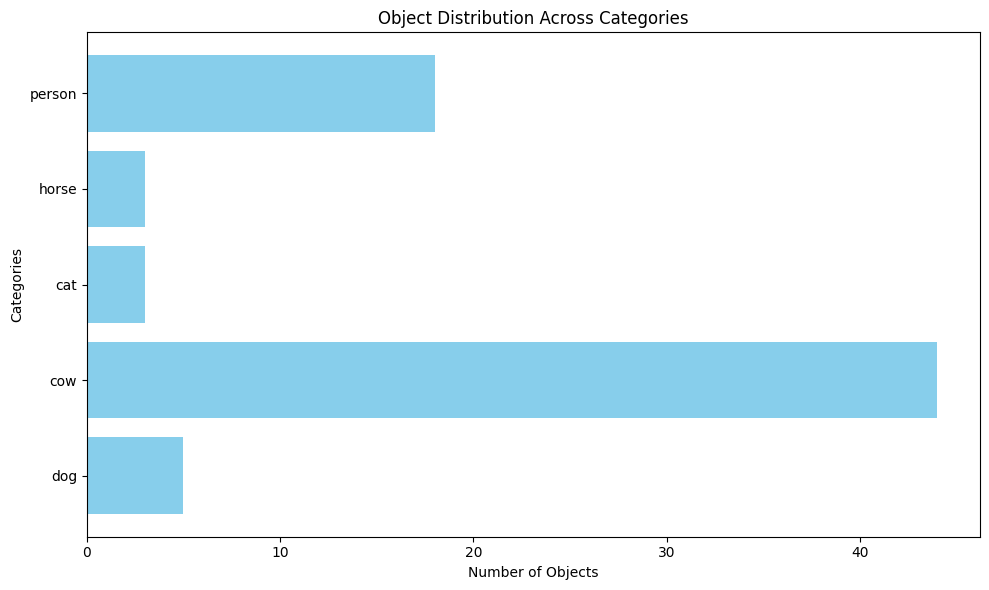

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1073189..2.4453342].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.192606..1.4995583].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.192606..2.4453342].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.192606..2.4453342].


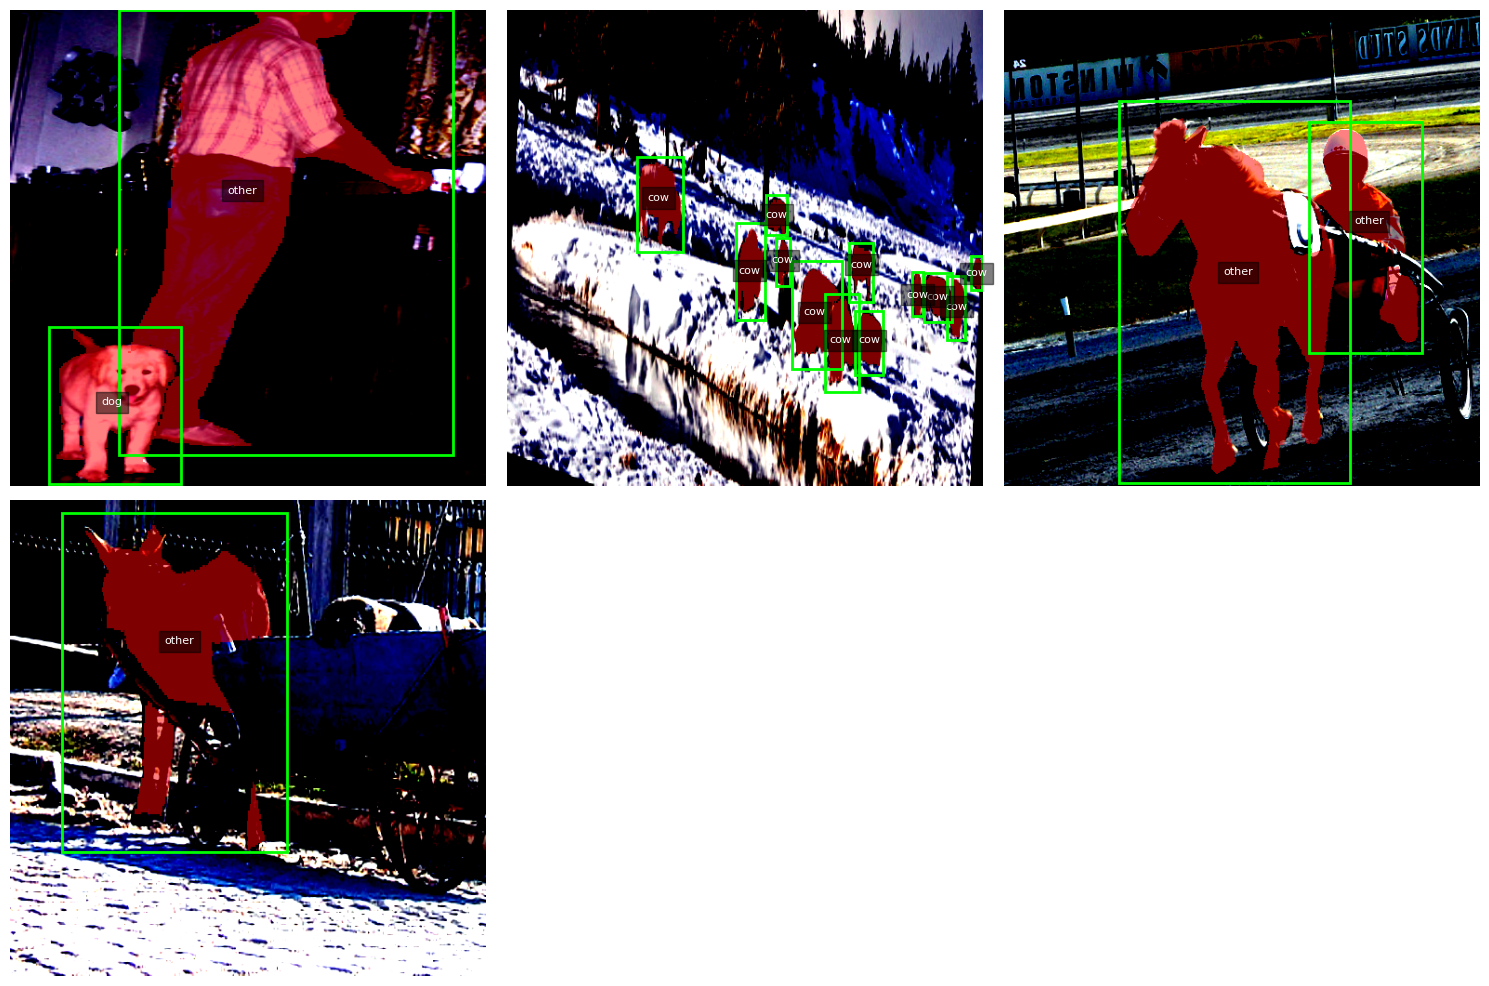

In [91]:
testdataset = CocoSegmentationDataset(val_dir, ['dog', 'cow'], ['cat','horse', 'person'], target_samples=4, negative_samples=4)

set_transforms(testdataset)
testdataset.show_data_distribution()

all_indexes = list(range(len(testdataset)))
index_slice = [0, 5, 8, 10]
testdataset.plot_images_at_indexes(index_slice, plot_bboxes=True)


# Data Loading

In [92]:
def coco_segmentation_collate_fn(batch):
    images, targets = zip(*batch)  # Unzips list of tuples
    return list(images), list(targets)


In [93]:
def create_dataloaders(dataset: CocoSegmentationDataset, batch_size=8, num_workers=0):
    train_dataset = copy.deepcopy(dataset)
    train_dataset.choose_split('train')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=coco_segmentation_collate_fn)
    
    val_dataset = copy.deepcopy(dataset)
    val_dataset.choose_split('val')
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=coco_segmentation_collate_fn)
    
    test_dataset = copy.deepcopy(dataset)
    test_dataset.choose_split('test')
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=coco_segmentation_collate_fn)
    
    return train_loader, val_loader, test_loader

# Base Model Constructors

In [94]:
class CustomMaskRCNNResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        num_classes = num_classes+1

        # Load a pre-trained ResNet-18 backbone with FPN
        backbone = resnet_fpn_backbone('resnet18', weights=ResNet18_Weights.DEFAULT)
        
        # Load a pre-trained Mask R-CNN model and replace the backbone with ResNet-18
        self.model = MaskRCNN(
            backbone=backbone,
            num_classes=num_classes,  # Make sure num_classes includes the background
        )
        
        # Replace the box predictor
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # Replace the mask predictor
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        self.model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
        
    def forward(self, images, targets=None):
        # Forward pass for training (with targets) or inference (without targets)
        return self.model(images, targets)


In [95]:
class CustomMaskRCNNResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CustomMaskRCNNResNet50, self).__init__()
        num_classes = num_classes+1

        # Load pre-trained Mask R-CNN with ResNet-50 backbone
        self.model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)

        # Replace the box predictor
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # Replace the mask predictor
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        self.model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    def forward(self, images, targets=None):
        return self.model(images, targets)

# Model Training and Evaluation Framework

In [96]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [97]:
def train_epoch(model, loader, optimizer, device, verbose=False):
    model.train()
    total_loss = 0

    for images, targets in tqdm(loader, disable=(not verbose), desc='Training'):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [98]:
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0.0
    return intersection / union

In [99]:
def coco_evaluate(model, data_loader, device, iou_type="segm", threshold=0.5, verbose=False):
    from pycocotools.coco import COCO
    from pycocotools.cocoeval import COCOeval
    import numpy as np
    import torch

    model.eval()
    results = []
    y_true = []
    y_pred = []
    all_scores = []
    ious = []
    fp = []
    fn = []

    for images, targets in tqdm(data_loader, disable=not verbose, desc='Validation'):
        images = [img.to(device) for img in images]
        outputs = model(images)

        for output, target in zip(outputs, targets):
            image_id = target["image_id"].item()
            pred_scores = output["scores"].detach().cpu().numpy()
            pred_labels = output["labels"].detach().cpu().numpy()
            pred_masks = output["masks"].detach().cpu().numpy() > threshold


            gt_labels = target["labels"].cpu().numpy()
            gt_masks = target["masks"].cpu().numpy() > threshold

            all_scores.extend(pred_scores.tolist())

            matched_gt = set()

            for i, (score, label, pred_mask) in enumerate(zip(pred_scores, pred_labels, pred_masks)):
                best_iou = 0
                best_j = -1
                for j, (gt_label, gt_mask) in enumerate(zip(gt_labels, gt_masks)):
                    iou = np.logical_and(pred_mask, gt_mask).sum() / np.logical_or(pred_mask, gt_mask).sum()
                    if iou > best_iou:
                        best_iou = iou
                        best_j = j

                ious.append(best_iou)

                if best_iou >= threshold:
                    matched_gt.add(best_j)
                    y_true.append(gt_labels[best_j])
                    y_pred.append(label)
                else:
                    y_true.append(-1)
                    y_pred.append(label)
                    fp.append((label, pred_mask))

                rle = maskUtils.encode(np.asfortranarray(pred_mask.squeeze(0).astype(np.uint8)))
                results.append({
                    "image_id": image_id,
                    "category_id": int(label),
                    "segmentation": rle,
                    "score": float(score),
                })

            for j, gt_label in enumerate(gt_labels):
                if j not in matched_gt:
                    fn.append((gt_label, gt_masks[j]))

    # COCO evaluation
    coco_gt = data_loader.dataset.coco
    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType=iou_type)

    if not verbose:
        with suppress_stdout():
            coco_eval.evaluate()
            coco_eval.accumulate()
            coco_eval.summarize()
    else:
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

    stats = coco_eval.stats  # [AP, AP50, AP75, APs, APm, APl, AR1, AR10, AR100, ARs, ARm, ARl]

    # Summarize false positives and negatives
    def summarize_counts(pairs):
        counts = {}
        for label, _ in pairs:
            label = int(label)
            counts[label] = counts.get(label, 0) + 1
        return counts

    fp_summary = summarize_counts(fp)
    fn_summary = summarize_counts(fn)
    y_true_count = dict(Counter(y_true))
    y_pred_count = dict(Counter(y_pred))

    return {
        "mAP": float(stats[0]),
        "mAP50": float(stats[1]),
        "mAP75": float(stats[2]),
        "AP_small": float(stats[3]),
        "AP_medium": float(stats[4]),
        "AP_large": float(stats[5]),
        "AR1": float(stats[6]),
        "AR10": float(stats[7]),
        "AR100": float(stats[8]),
        "AR_small": float(stats[9]),
        "AR_medium": float(stats[10]),
        "AR_large": float(stats[11]),
        "precision_summary": {
            "mean": float(np.mean(coco_eval.eval['precision'])),
            "median": float(np.median(coco_eval.eval['precision'])),
            "min": float(np.min(coco_eval.eval['precision'])),
            "max": float(np.max(coco_eval.eval['precision'])),
        },
        "recall_summary": {
            "mean": float(np.mean(coco_eval.eval['recall'])),
            "median": float(np.median(coco_eval.eval['recall'])),
            "min": float(np.min(coco_eval.eval['recall'])),
            "max": float(np.max(coco_eval.eval['recall'])),
        },
        "ious_summary": {
            "mean": float(np.mean(ious)),
            "min": float(np.min(ious)),
            "max": float(np.max(ious)),
        },
        "scores": [float(s) for s in all_scores],
        "y_true": y_true_count,
        "y_pred": y_pred_count,
        "fp_summary": fp_summary,
        "fn_summary": fn_summary,
        "raw_y_true": y_true,  # for confusion matrix
        "raw_y_pred": y_pred,  # for confusion matrix
        "raw_scores": all_scores,
        "raw_ious": ious
    }

"""
def coco_evaluate(model, data_loader, device, iou_type="segm", threshold=0.5, verbose=False):
    model.eval()
    results = []
    y_true = []  
    y_pred = []
    ious = []
    fp = []
    fn = []
    all_scores = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, disable=not verbose, desc='Validation'):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                image_id = target["image_id"].item()
                pred_scores = output["scores"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()
                pred_masks = output["masks"].cpu().numpy() > threshold

                gt_labels = target["labels"].cpu().numpy()
                gt_masks = target["masks"].cpu().numpy() > threshold

                all_scores.extend(pred_scores.tolist())

                matched_gt = set()
                
                for i, (score, label, pred_mask) in enumerate(zip(pred_scores, pred_labels, pred_masks)):
                    best_iou = 0
                    best_j = -1
                    for j, (gt_label, gt_mask) in enumerate(zip(gt_labels, gt_masks)):
                        iou = calculate_iou(pred_mask, gt_mask)
                        if iou > best_iou:
                            best_iou = iou
                            best_j = j
                    
                    ious.append(best_iou)

                    # FP or matched
                    if best_iou >= threshold:
                        matched_gt.add(best_j)
                        y_true.append(gt_labels[best_j])
                        y_pred.append(label)
                    else:
                        fp.append((label, pred_mask))
                        y_true.append(-1)
                        y_pred.append(label)

                    # COCO result
                    mask_np = pred_mask.squeeze(0).astype(np.uint8)
                    rle = maskUtils.encode(np.asfortranarray(mask_np))
                    results.append({
                        "image_id": image_id,
                        "category_id": int(label),
                        "segmentation": rle,
                        "score": float(score),
                    })

                # FN: any GT masks that weren't matched
                for j, gt_label in enumerate(gt_labels):
                    if j not in matched_gt:
                        fn.append((gt_label, gt_masks[j]))
    
    if verbose:
        coco_gt = data_loader.dataset.coco
        coco_dr = coco_gt.loadRes(results)
        coco_eval = COCOeval(coco_gt, coco_dr, iou_type)
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
    else:
        with suppress_stdout():
            coco_gt = data_loader.dataset.coco
            coco_dr = coco_gt.loadRes(results)
            coco_eval = COCOeval(coco_gt, coco_dr, iou_type)
            coco_eval.evaluate()
            coco_eval.accumulate()
            coco_eval.summarize()

    stats = coco_eval.stats  # [AP, AP50, AP75, APs, APm, APl, AR1, AR10, AR100, ARs, ARm, ARl]
    
    fp_summary = {}
    for label, mask in fp:
        if label not in fp_summary:
            fp_summary[label] = 0
        fp_summary[label] += 1
    
    fp_summary = {int(key): value for key, value in fp_summary.items()}
    
    fn_summary = {}
    for label, mask in fn:
        if label not in fn_summary:
            fn_summary[label] = 0
        fn_summary[label] += 1
    
    fn_summary = {int(key): value for key, value in fn_summary.items()}
    
    y_true_count = Counter(y_true)
    y_true_count = {int(key): value for key, value in y_true_count.items()}

    y_pred_count = Counter(y_pred)
    y_pred_count = {int(key): value for key, value in y_pred_count.items()}
    
    precision = coco_eval.eval['precision']
    precision_mean = np.mean(precision)
    precision_median = np.median(precision)
    precision_min = np.min(precision)
    precision_max = np.max(precision)
    
    recall = coco_eval.eval['recall']
    recall_mean = np.mean(recall)
    recall_median = np.median(recall)
    recall_min = np.min(recall)
    recall_max = np.max(recall)
    
    ious_mean = np.mean(ious)
    ious_min = np.min(ious)
    ious_max = np.max(ious)

    return {
        "mAP": float(stats[0]),
        "mAP50": float(stats[1]),
        "mAP75": float(stats[2]),
        "AP_small": float(stats[3]),
        "AP_medium": float(stats[4]),
        "AP_large": float(stats[5]),
        "AR1": float(stats[6]),
        "AR10": float(stats[7]),
        "AR100": float(stats[8]),
        "AR_small": float(stats[9]),
        "AR_medium": float(stats[10]),
        "AR_large": float(stats[11]),
        "precision_summary": {
            "mean": precision_mean,
            "median": precision_median,
            "min": precision_min,
            "max": precision_max
        },
        "recall_summary": {
            "mean": recall_mean,
            "median": recall_median,
            "min": recall_min,
            "max": recall_max
        },
        "scores": [float(s) for s in all_scores],
        "ious_summary": {
            "mean": ious_mean,
            "min": ious_min,
            "max": ious_max
        },
        "y_true": y_true_count,
        "y_pred": y_pred_count,
        "fp_summary": fp_summary,
        "fn_summary": fn_summary
    }
"""

'\ndef coco_evaluate(model, data_loader, device, iou_type="segm", threshold=0.5, verbose=False):\n    model.eval()\n    results = []\n    y_true = []  \n    y_pred = []\n    ious = []\n    fp = []\n    fn = []\n    all_scores = []\n\n    with torch.no_grad():\n        for images, targets in tqdm(data_loader, disable=not verbose, desc=\'Validation\'):\n            images = [img.to(device) for img in images]\n            outputs = model(images)\n\n            for output, target in zip(outputs, targets):\n                image_id = target["image_id"].item()\n                pred_scores = output["scores"].cpu().numpy()\n                pred_labels = output["labels"].cpu().numpy()\n                pred_masks = output["masks"].cpu().numpy() > threshold\n\n                gt_labels = target["labels"].cpu().numpy()\n                gt_masks = target["masks"].cpu().numpy() > threshold\n\n                all_scores.extend(pred_scores.tolist())\n\n                matched_gt = set()\n\n           

In [100]:
def train_and_save_model(model, train_loader, val_loader, optimizer, device, epochs=10, metric_type='mAP', threshold=0.5, scheduler=None, save_dir="../models", model_name="model" , notes='NA', verbose=True,):    # Initialize lists to store the results
    # Initialize stats dictionary
    epoch_stats = {}
    
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # To track the best model based on validation accuracy
    best_score = 0.0
    best_train_loss = 0.0
    best_model_state = model.state_dict() #Initial models state

    for epoch in tqdm(range(epochs), disable=verbose, desc="Total Epochs"):
        if verbose: print(f'Epoch {epoch+1}') 
        
        #Train the model
        train_loss = train_epoch(model, train_loader, optimizer, device, verbose)
        
        #Evaluate the model
        val_stats = coco_evaluate(model, val_loader, device, iou_type='segm', threshold=threshold, verbose=verbose)
        
        # Get the metric type were using to score
        if metric_type in val_stats and metric_type != "raw_stats":
            score = val_stats[metric_type] 
        else:
            print(f"Metric type {metric_type} is not supported, using mAP")
            score = val_stats['mAP'] 

        if scheduler:
            scheduler.step(val_stats['mAP'])
        
        # Organize the stats by epoch
        epoch_stats[epoch + 1] = {
            "train_loss": train_loss,
            "lr": optimizer.param_groups[0]['lr'],
            "val_coco_stats": val_stats
        }
        
        if score > best_score:
            best_score = score
            best_train_loss = train_loss
            best_model_state = model.state_dict()
            if verbose: print(f"*****New Best Model!*****")
        
        if verbose: print(f"Train: Loss {train_loss:.4f} | Val mAP: {score:.4f}")
        if verbose: print('----------------------------------------------------------')
        
    #set the names for the save paths
    if not model_name.lower().endswith(".pth"):
        stats_name = f"{model_name}_stats.json"
        info_name = f"{model_name}_info.json"
        model_name += ".pth"
    else:
        stats_name = f"{model_name.replace('.pth', '')}_stats.json"
        info_name = f"{model_name.replace('.pth', '')}_info.json"
        
    # Save the model 
    model_save_path = os.path.join(save_dir, model_name)
    torch.save(best_model_state, model_save_path)
    print(f"Best train loss: {best_train_loss:.6f}")
    print(f"Best mAP: {best_score:.6f}")
    print(f"Model saved at {model_save_path}")

    # Save the statistics
    stats_save_path = os.path.join(save_dir, stats_name)
    def sanitize_dict(d):
        if isinstance(d, dict):
            return {str(k): sanitize_dict(v) for k, v in d.items()}
        elif isinstance(d, list):
            return [sanitize_dict(i) for i in d]
        elif isinstance(d, (np.integer, np.floating)):
            return d.item()
        return d

    sanitized_epoch_stats = sanitize_dict(epoch_stats)
    
    with open(stats_save_path, 'w') as f:
        json.dump(sanitized_epoch_stats, f, indent=4)
    print(f"Statistics saved at {stats_save_path}")
    
    # Save model metadata
    model_info = {
        "model_name": model_name,
        "architecture": str(model.__class__.__name__),
        "optimizer": str(optimizer.__class__.__name__),
        "hyperparameters": {
            "learning_rate": optimizer.param_groups[0]['lr'],
            "epochs": epochs,
            # Add other relevant hyperparameters like weight_decay, momentum, etc.
        },
        "threshold" : threshold,
        "metric_used": metric_type,
        "best_score": best_score,
        "best_train_loss": best_train_loss,
        "dataset": {
            "target_categories": train_loader.dataset.target_categories,
            "n_target_samples" : train_loader.dataset.desired_target_samples,
            "negative_categories": train_loader.dataset.negative_categories,
            "n_negative_samples": train_loader.dataset.desired_negative_samples,
            "train_ratio" : train_loader.dataset.train_ratio,
            "val_ratio" : train_loader.dataset.val_ratio,
            "test_ratio" : train_loader.dataset.test_ratio,
        },
        "notes": notes,
        # "transforms" : serialize_transform(train_loader.dataset.transforms),
        # "timestamp": datetime.datetime.now().isoformat(),
    }

    model_info_path = os.path.join(save_dir, info_name)
    with open(model_info_path, 'w') as f:
        json.dump(model_info, f, indent=4)
    print(f"Model info saved at {model_info_path}")
    
    return {
        "epoch_stats": epoch_stats,
        "best_score": best_score,
        "model_path": model_save_path,
    }
    

# Baseline Model

In [101]:
print("put baseline here")

put baseline here


# Test Suite

### training stats

you can probably expand or refactor this class to work with either a json or actual training data, we could essentially reuse the evaluate function and then dump it into a model evaluation json and then use that to see how our model tests

In [102]:
"""
class TrainingMetricsPlotter:
    def __init__(self, json_path):
        self.json_path = json_path
        self.metrics = {}
        self._load_json()

    def _load_json(self):
        with open(self.json_path, 'r') as f:
            self.metrics = json.load(f)
        # Ensure keys are sorted numerically as integers
        self.metrics = {int(k): v for k, v in self.metrics.items()}
        self.metrics = dict(sorted(self.metrics.items()))

    def plot_epochs(self):
        epochs = list(self.metrics.keys())
        train_loss = [self.metrics[e]['train_loss'] for e in epochs]
        mAP = [self.metrics[e]['val_coco_stats']['mAP'] for e in epochs]
        mAP50 = [self.metrics[e]['val_coco_stats']['mAP50'] for e in epochs]
        mAP75 = [self.metrics[e]['val_coco_stats']['mAP75'] for e in epochs]
        
        ap_small = [self.metrics[e]['val_coco_stats']['AP_small'] for e in epochs]
        ap_medium = [self.metrics[e]['val_coco_stats']['AP_medium'] for e in epochs]
        ap_large = [self.metrics[e]['val_coco_stats']['AP_large'] for e in epochs]

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_loss, label='Train Loss', marker='.')
        plt.plot(epochs, mAP, label='mAP', marker='o')
        plt.plot(epochs, mAP50, label='mAP50', marker='o')
        plt.plot(epochs, mAP75, label='mAP75', marker='o')
        plt.plot(epochs, ap_small, label='AP Small', marker='x')
        plt.plot(epochs, ap_medium, label='AP Medium', marker='x')
        plt.plot(epochs, ap_large, label='AP Large', marker='x')

        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.title('Training Metrics vs Epoch')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

"""
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import json

class TrainingMetricsPlotter:
    def __init__(self, json_path):
        self.json_path = json_path
        self.metrics = {}
        self._load_json()

    def _load_json(self):
        with open(self.json_path, 'r') as f:
            self.metrics = json.load(f)
        self.metrics = {int(k): v for k, v in self.metrics.items()}
        self.metrics = dict(sorted(self.metrics.items()))

    def plot_epochs(self):
        epochs = list(self.metrics.keys())
        train_loss = [self.metrics[e]['train_loss'] for e in epochs]
        mAP = [self.metrics[e]['val_coco_stats']['mAP'] for e in epochs]
        mAP50 = [self.metrics[e]['val_coco_stats']['mAP50'] for e in epochs]
        mAP75 = [self.metrics[e]['val_coco_stats']['mAP75'] for e in epochs]
        ap_small = [self.metrics[e]['val_coco_stats']['AP_small'] for e in epochs]
        ap_medium = [self.metrics[e]['val_coco_stats']['AP_medium'] for e in epochs]
        ap_large = [self.metrics[e]['val_coco_stats']['AP_large'] for e in epochs]

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_loss, label='Train Loss', marker='.')
        plt.plot(epochs, mAP, label='mAP', marker='o')
        plt.plot(epochs, mAP50, label='mAP50', marker='o')
        plt.plot(epochs, mAP75, label='mAP75', marker='o')
        plt.plot(epochs, ap_small, label='AP Small', marker='x')
        plt.plot(epochs, ap_medium, label='AP Medium', marker='x')
        plt.plot(epochs, ap_large, label='AP Large', marker='x')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.title('Training Metrics vs Epoch')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_score_distribution(self, epoch=None):
        if epoch is None:
            epoch = max(self.metrics.keys())
        scores = self.metrics[epoch]['val_coco_stats'].get('raw_scores', [])
        plt.figure(figsize=(8, 4))
        plt.hist(scores, bins=30, color='skyblue')
        plt.xlabel("Confidence Score")
        plt.ylabel("Frequency")
        plt.title(f"Score Distribution (Epoch {epoch})")
        plt.tight_layout()
        plt.show()

    def plot_iou_distribution(self, epoch=None):
        if epoch is None:
            epoch = max(self.metrics.keys())
        ious = self.metrics[epoch]['val_coco_stats'].get('raw_ious', [])
        plt.figure(figsize=(8, 4))
        plt.hist(ious, bins=20, color='orange')
        plt.xlabel("IoU")
        plt.ylabel("Frequency")
        plt.title(f"IoU Distribution (Epoch {epoch})")
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, epoch=None, class_names=None):
        if epoch is None:
            epoch = max(self.metrics.keys())
        y_true = self.metrics[epoch]['val_coco_stats'].get('raw_y_true', [])
        y_pred = self.metrics[epoch]['val_coco_stats'].get('raw_y_pred', [])

        if not y_true or not y_pred:
            print("Missing confusion matrix data.")
            return

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap='Blues', xticks_rotation=45)
        plt.title(f"Confusion Matrix (Epoch {epoch})")
        plt.tight_layout()
        plt.show()

    def plot_pr_curve(self, epoch=None):
        if epoch is None:
            epoch = max(self.metrics.keys())
        y_true = self.metrics[epoch]['val_coco_stats'].get('raw_y_true', [])
        y_scores = self.metrics[epoch]['val_coco_stats'].get('raw_scores', [])

        # Filter out -1 labels (false positives)
        y_true_bin = [1 if y != -1 else 0 for y in y_true]

        if not y_true_bin or not y_scores:
            print("Missing data for PR curve.")
            return

        precision, recall, _ = precision_recall_curve(y_true_bin, y_scores)
        plt.figure(figsize=(8, 5))
        plt.plot(recall, precision, label='PR Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve (Epoch {epoch})')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_fp_fn_summary(self, epoch=None):
        if epoch is None:
            epoch = max(self.metrics.keys())
        fp = self.metrics[epoch]['val_coco_stats'].get('fp_summary', {})
        fn = self.metrics[epoch]['val_coco_stats'].get('fn_summary', {})

        labels = sorted(set(fp.keys()) | set(fn.keys()))
        fp_vals = [fp.get(str(k), 0) for k in labels]
        fn_vals = [fn.get(str(k), 0) for k in labels]

        x = range(len(labels))
        plt.figure(figsize=(10, 5))
        plt.bar(x, fp_vals, width=0.4, label='False Positives', align='center')
        plt.bar(x, fn_vals, width=0.4, label='False Negatives', align='edge')
        plt.xticks(x, labels)
        plt.xlabel("Class Label")
        plt.ylabel("Count")
        plt.title(f"FP/FN Summary (Epoch {epoch})")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_all(self):
        self.plot_epochs()
        self.plot_score_distribution()
        self.plot_iou_distribution()
        self.plot_fp_fn_summary()
        self.plot_pr_curve()


todo for above, Category-wise APS, PR Curve, Confusion matrix (Maybe), Qualitative Visualizations, Score Distribution,  False Positive / False Negative Analysis, IoU Distribution

### Test Suite

# Model Training and Results Section

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [104]:
target_categories = ['dog'] #Categories to train for
negative_categories = [] #Categories to train as not targets
num_classes = len(target_categories)
if negative_categories: num_classes += 1 #If we have at least one "other" as all negatives are counted as the same class
defaultMaskRcnn18 = CustomMaskRCNNResNet18(num_classes)
DogOnlyDataset = CocoSegmentationDataset(val_dir, target_categories=target_categories, target_samples=8)

set_transforms(DogOnlyDataset)
model_name = 'DogOnly'
epochs = 2
optimizer = optim.Adam(defaultMaskRcnn18.parameters(), lr=1e-4)

DogOnly_train_loader, DogOnly_val_loader, DogOnly_test_loader = create_dataloaders(DogOnlyDataset)

#Comment out once trained
model_info = train_and_save_model(model=defaultMaskRcnn18, 
                                  train_loader=DogOnly_train_loader,
                                  val_loader=DogOnly_val_loader,
                                  optimizer=optimizer,
                                  device=device,
                                  epochs=epochs,
                                  metric_type = 'mAP',
                                  model_name=model_name,
                                  verbose=False
                            )
                                  

c:\Users\101083339\Documents\CS445\CS445-Project\.venv\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


loading annotations into memory...
Done (t=5.16s)
creating index...
index created!
Verifying Local Images...


100%|██████████| 8/8 [00:00<00:00, 4211.68it/s]

No Mean or STD found, Calculating...


Mean: (114.11421203613281, 107.25884246826172, 103.21890258789062) --- STD: (60.322349548339844, 59.379661560058594, 60.5883674621582)


Total Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!


Total Epochs:  50%|█████     | 1/2 [02:02<02:02, 122.26s/it]

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!


Total Epochs: 100%|██████████| 2/2 [03:19<00:00, 99.81s/it] 


Best train loss: 0.000000
Best mAP: 0.000000
Model saved at ../models\DogOnly.pth
Statistics saved at ../models\DogOnly_stats.json
Model info saved at ../models\DogOnly_info.json


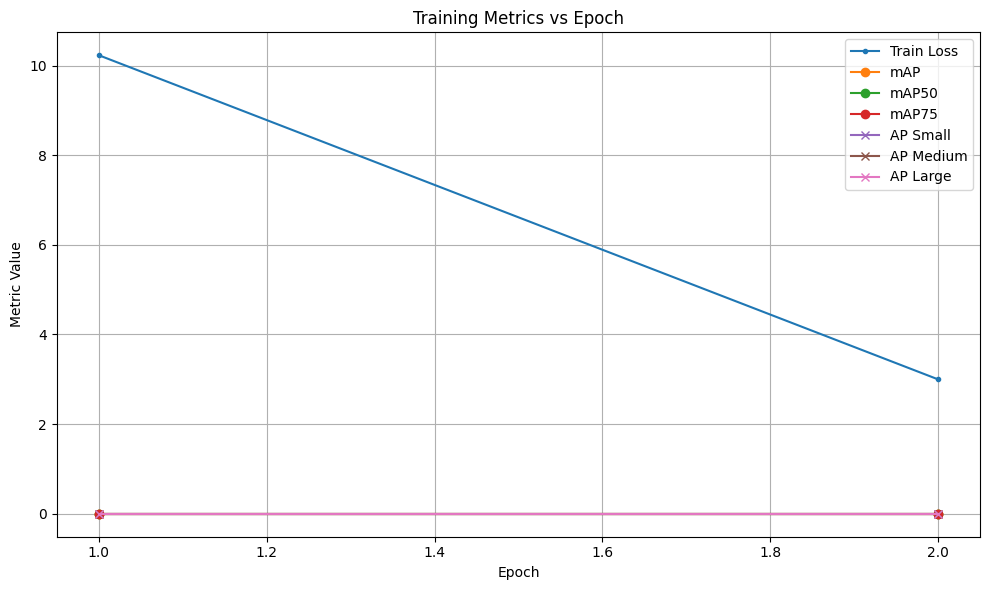

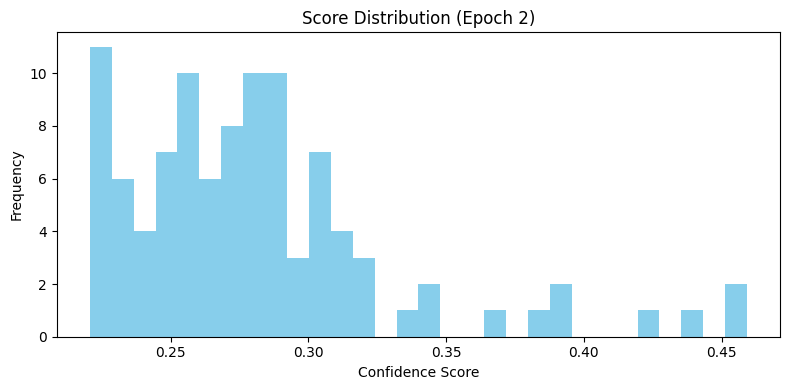

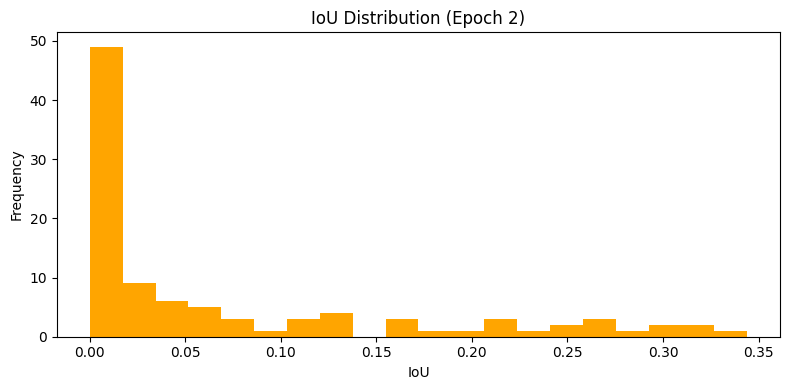

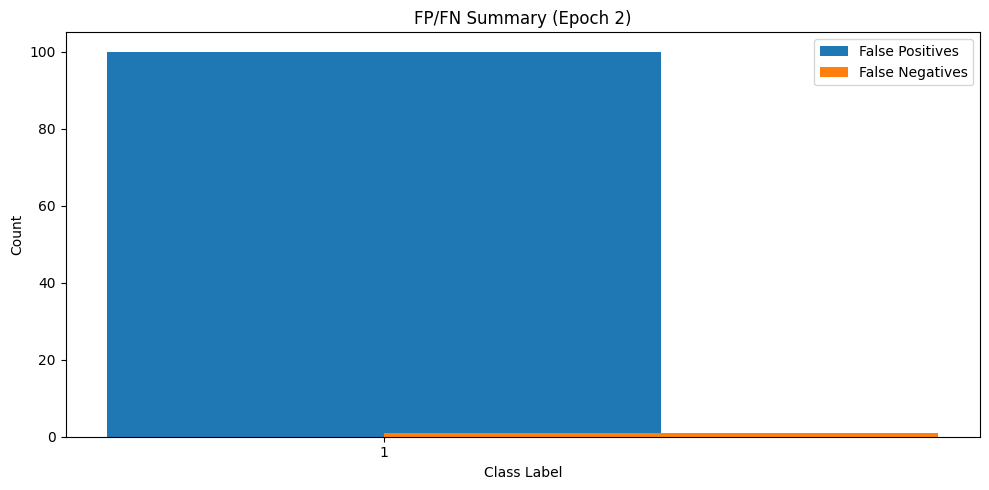

c:\Users\101083339\Documents\CS445\CS445-Project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


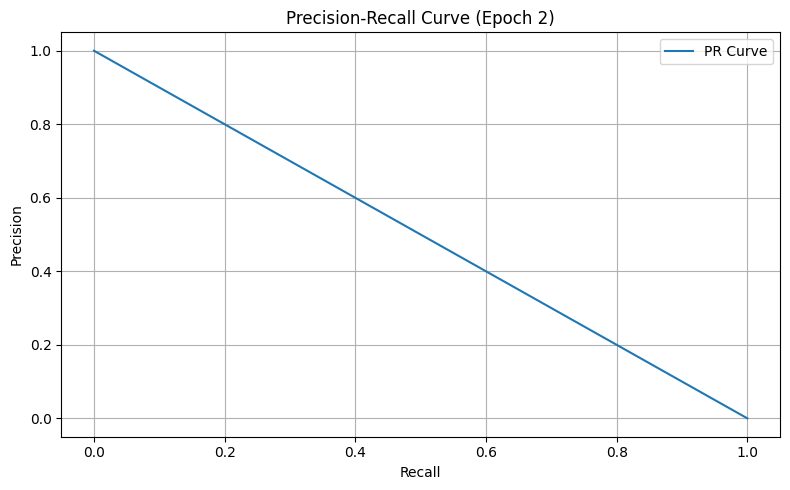

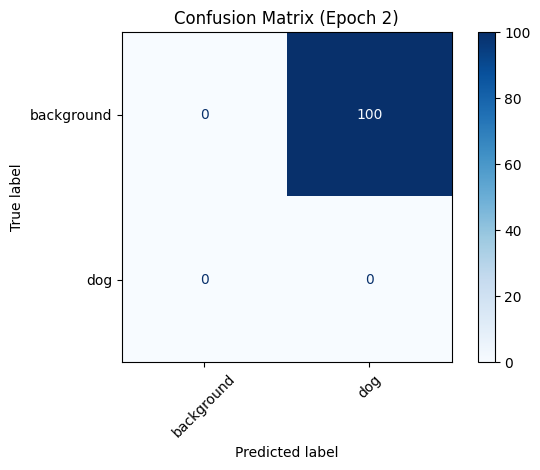

In [105]:
plotter = TrainingMetricsPlotter('../models/DogOnly_stats.json')
plotter.plot_all()
plotter.plot_confusion_matrix(class_names=["background", "dog"])  # adjust as needed


# Interpretation of the results
To assess the performance of our instance segmentation model, we plotted training metrics, evaluation statistics, and diagnostic visualizations. These were based on training the model for 2 epochs using a small subset of COCO data filtered to only include the "dog" category. 

### Training Metrics
The training loss consistently decreased over the two epochs, indicating that the model was learning to fit the training data. However, all AP (Average Precision) and AR (Average Recall) metrics remained at zero across small, medium, and large objects. This suggests that although the model learned something, it failed to generalize to the validation set.

### Confusion Matrix
The confusion matrix revealed a clear failure in correct classification. All predicted labels were "dog", including for background regions, resulting in:
100 false positives for the "dog" class
0 true positives
0 detections for the actual "dog" instances
This indicates that the model may have overfit to the foreground class or failed to learn any meaningful features due to data sparsity.

### Precision-Recall Curve
The PR curve is nearly linear and diagonal, indicating no separation between positive and negative predictions. This again reinforces that the model struggled to assign high confidence scores to correct detections.

### False Positive / False Negative Summary
There is a very large number of false positives (100+) and virtually no correct detections. This pattern confirms that the model:
Misclassified background as "dog"
Missed all real dogs, resulting in false negatives

### IoU Distribution
The Intersection-over-Union (IoU) distribution is highly skewed toward zero. Most predicted masks do not overlap meaningfully with ground truth masks, reflecting poor spatial alignment.

### Score Distribution
Confidence scores are tightly clustered between 0.2 and 0.45, with no predictions having strong confidence. This distribution suggests that the model has low certainty in all its outputs, further indicating a lack of robust learning.

